In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
import geopandas as gpd
import random
from scipy.stats import truncnorm
from collections import defaultdict
import math

In [2]:
np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)

In [3]:
os.getcwd()

'C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\notebooks'

In [4]:
os.chdir("..")

In [5]:
category_stats = pd.read_csv("./data/cleaned_data/category_stats.csv")
fraud_kaggle = pd.read_csv("data/raw_data/fraudTest.csv.zip", compression="zip")

# Создание паттернов времени - распределений времени активности
**Аннотация**<br>
Будет создано несколько распределений времени. На данный момент 6 распределений:
1. круглосуточные категории, НЕ фрод:
	- основной пик в районе 18-19. от 18 до 22 примерно
2. Кругосуточные категории - фрод
	- равномерно днем и ночью равномерно, но меньше чем днем
3. Онлайн категории, НЕ фрод
	- Пик Вечером после 18. между 18 и 22 включительно
4. Онлайн фрод
	- равномерно днем и пик вечером-ночью
5. дневной оффлайн - НЕ фрод.
	- Обрезанное распределение круглосуточных оффлайн категорий. Без позднего вечера и ночи.
6. дневной оффлайн - фрод
	- равномерно с 8 до 22.

Далее под обозначением часа 0,1,2,3 ... 23; имеется в виду соотвествие обозначения периодам времени:<br>
0 - от 00:00 до 00:59<br>
1 - от 01:00 до 01:59<br>
3 - от 03:00 до 03:59<br>
... <br>
23 - от 23:00 до 23:59 <br>

Т.е. вероятностный вес часа (распределение времени), это вероятность получить время в рамках соответсвующего периода
Эти веса будут позже применены при генерации транзакций. В зависимости от характеристик транзакции время транзакции будет случайно браться из массива отметок времени (через `pd.Series.sample`), и каждая отметка будет иметь свою вероятность на основании веса для её часа

## Прототипирование паттернов времени

### Круглосуточные legit веса - прототип

In [6]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
mean_morn = 9 * 60
std_morn = 90
morn_start = 6 * 60

# Truncated normal - пик утро
dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
minutes_morn = dist_morn.rvs(3000).astype(int)

# небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
mean_noon = 14 * 60
std_noon= 75
noon_end = 16.5 * 60

# Truncated normal - пик обед
dist_noon = truncnorm((start - mean_noon)/ std_noon, noon_end / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(5000).astype(int)


# Вечерний пик. В районе 19 часов
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 23.3 * 60

# Truncated normal - пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, evn_end / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(9000).astype(int)

# ночная равномерная небольшая активность с 0 до 6:50 утра включительно
night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)

# соединяем все созданные массивы в один
minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

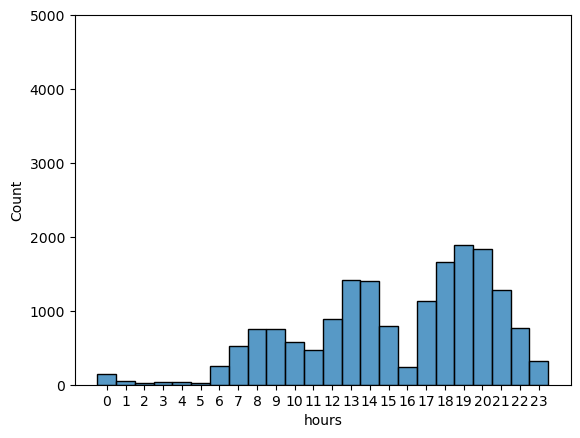

In [7]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0, 5000);

### Круглосуточные оффлайн категории - фрод. Прототип

In [8]:
# равномерная активность с 8 до 23
day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)

# равномерная сниженная активность с 0 до 8
night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)

# соединяем все созданные массивы в один и делаем серией
hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")

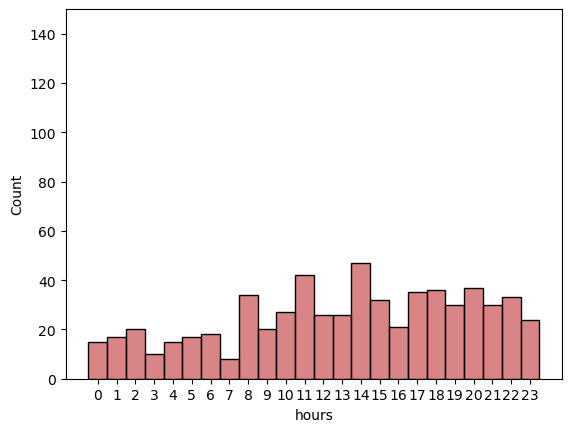

In [9]:
p = sns.histplot(x=hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=hours.unique())
p.set_ylim(0, 150);

### Онлайн категории, НЕ фрод
	- Пик Вечером после 18. между 18 и 22 включительно

In [10]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# равномерно с утра до вечера. с 8 до 16 включительно.
day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)


# небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
mean_noon = 14 * 60
std_noon= 75
noon_start = 12 * 60
noon_end = 16.5 * 60

# пик обед
dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(400).astype(int)


# Вечерний пик. От 17 до 23 часов.
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 23.3 * 60

# пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(2000).astype(int)

# ночная равномерная низкая активность с 0 до 7:59 утра
night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)

# соединяем все созданные массивы в один
minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

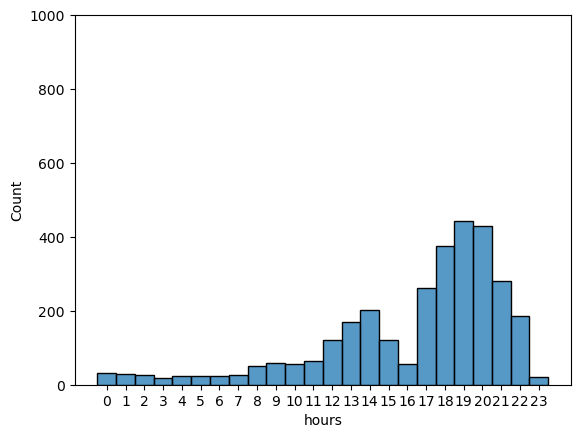

In [11]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True)
p.set_xticks(ticks=time_hours.unique())
p.set_ylim(0, 1000);

### Онлайн фрод - прототип

In [12]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59


# Ночной пик после 00:00
mean = 1
std = 120

# распределение ночного пика
dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
minutes = dist.rvs(2000).astype(int)

# Добавление веса для вечернего периода (среднее 23:00 - 1140 минут)
mean_evn = 23.9*60
std_evn = 120
evn_end = 23.9*60

# Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(2000).astype(int)

# добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
mid_start = 4 * 60
mid_end = 20.9 * 60
midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)

# соединяем все три массива
total_minutes = np.concatenate((minutes, midday_add, minutes_evn))

times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
time_hours = times.hours

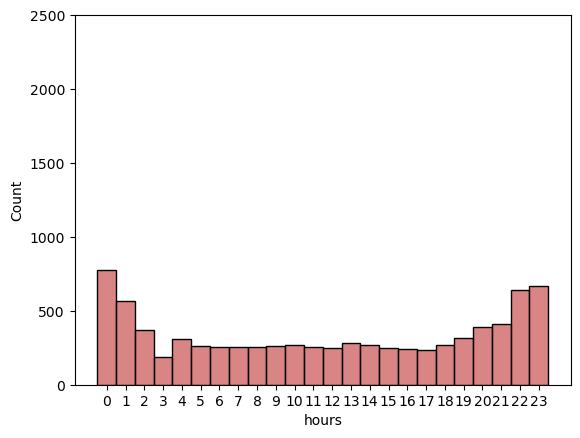

In [13]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,2500);

### Дневной оффлайн - НЕ фрод. Прототип

In [14]:
# Время в минутах с начала суток
start, end = 0, 1439  # 00:00 до 23:59

# равномерное распределение с 8:00 до 17:00
day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)

# слабый пик обед в районе 13. Интервал с 12 до 17:00
mean_noon = 14 * 60
std_noon= 75
noon_start = 12 * 60
noon_end = 16.5 * 60

# пик обед
dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
minutes_noon = dist_noon.rvs(1500).astype(int)


# Вечерний пик. С 17:00 до 22:00
mean_evn = 19.7 * 60
std_evn = 120
evn_start = 17 * 60
evn_end = 21.9 * 60

# пик вечером
dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
minutes_evn = dist_evn.rvs(9000).astype(int)


# соединяем все созданные массивы в один
minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #

# переводим значения массива в тип pd.Timedelta.
# Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
# берем hours оттуда
times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
time_hours = times.hours

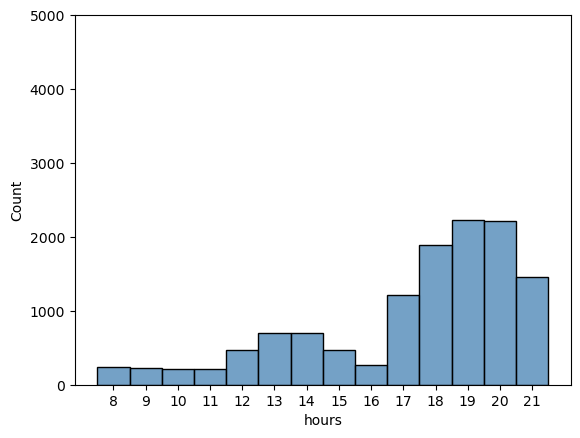

In [15]:
p = sns.histplot(x=time_hours, binwidth=1, discrete=True, color="steelblue")
p.set_xticks(ticks=time_hours.sort_values().unique())
p.set_ylim(0,5000);

### Дневной оффлайн. Фрод - Прототип

In [16]:
# равномерная активность с 8:00 до 22:00
day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)

# 
time_hours = pd.Series(day_time, name="hours")

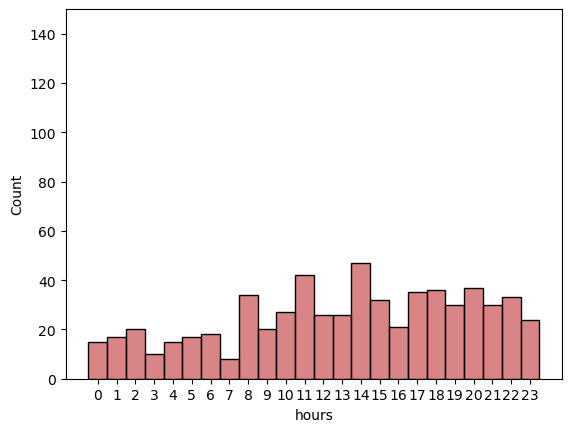

In [17]:
p = sns.histplot(x=hours, binwidth=1, discrete=True, color="indianred")
p.set_xticks(ticks=hours.unique())
p.set_ylim(0, 150);

# Функция генерации весов для часов в периоде времени
Собрана на основании прототипов выше

In [18]:
def gen_weights_for_time(is_fraud=False, round_clock=False, online=False):
    """
    возвращает датафрейм с часами от 0 до 23 и из весами,
    название паттерна в виде строки и цвет для возможного графика - в зависимости от фрод не фрод
    
    is_fraud - True или False. По умолчанию False
    round_clock - Круглосуточная категория или нет. True или False. По умолчанию False
    online - None, True или False. По умолчанию False
    """
    # Время в минутах с начала суток. Чтобы ограничить распределения
    start, end = 0, 1439  # 00:00 до 23:59

    #  Далее в зависимости от условий генерация распределения времени для транзакций
    
    # 1. Категория - круглосуточные, оффлайн, НЕ фрод 
    if not is_fraud and round_clock and not online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. 24h. Legit"
        
        # небольшой пик утром в районе 9. Обрезаный слева по 6-и утра
        mean_morn = 9 * 60
        std_morn = 90
        morn_start = 6 * 60
        
        # Truncated normal - пик утро
        dist_morn = truncnorm((morn_start - mean_morn)/ std_morn, (end - mean_morn) / std_morn, loc=mean_morn, scale=std_morn)
        minutes_morn = dist_morn.rvs(3000).astype(int)
        
        # небольшой пик обед в районе 13. Обрезанный по 16-и часам справа
        mean_noon = 14 * 60
        std_noon= 75
        noon_end = 16.5 * 60
        
        # Truncated normal - пик обед
        dist_noon = truncnorm((start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(5000).astype(int)
        
        
        # Вечерний пик. В районе 19 часов
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 23.3 * 60
        
        # Truncated normal - пик вечером
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(9000).astype(int)
        
        # ночная равномерная небольшая активность с 0 до 6:50 утра включительно
        night_hours_add =  np.array([np.random.uniform(0, 710) for _ in range(300)]).astype(int)
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((minutes_morn, minutes_noon, minutes_evn, night_hours_add), axis=0) #  

        # переводим значения массива в тип pd.Timedelta.
        # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
        # берем hours оттуда
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours

    # 2. оффлайн фрод. круглосуточные категории
    elif is_fraud and round_clock and not online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. 24h. Fraud"
        
        # равномерная активность с 8 до 23
        day_time =  np.array([np.random.uniform(8, 23.9) for _ in range(500)]).astype(int)
        
        # равномерная сниженная активность с 0 до 8
        night_time = np.array([np.random.uniform(0, 7.9) for _ in range(120)]).astype(int)
        
        # соединяем все созданные массивы в один и делаем серией
        time_hours = pd.Series(np.concatenate((day_time, night_time), axis=0), name="hours")


    # 3. НЕ фрод. Онлайн покупки
    elif not is_fraud and round_clock and online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Online. Legit"
        
        # равномерно с утра до вечера. с 8:00 до 16:59
        day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(500)]).astype(int)
        
        
        # небольшой пик обед в районе 13. Обрезанный по 12 и 17 часам
        mean_noon = 14 * 60
        std_noon= 75
        noon_start = 12 * 60
        noon_end = 16.5 * 60
        
        # пик обед. Распределение
        dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(400).astype(int)
        
        
        # Вечерний пик. От 17 до 23 часов.
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 23.3 * 60
        
        # пик вечером. Распределение
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(2000).astype(int)
        
        # ночная равномерная низкая активность с 0 до 7:59 утра
        night_hours_add = np.array([np.random.uniform(0, 7.9*60) for _ in range(200)]).astype(int)
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((day_time, minutes_noon, minutes_evn, night_hours_add), axis=0) #  
        
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours
        
    # 4. онлайн фрод
    elif is_fraud and round_clock and online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Online. Fraud"
        
        # Ночной пик после 00:00
        mean = 1
        std = 120
        
        # распределение ночного пика
        dist = truncnorm((start - mean) / std, (end - mean) / std, loc=mean, scale=std)
        minutes = dist.rvs(2000).astype(int)
        
        # Добавление веса для вечернего периода (среднее 23:00 - 1140 минут)
        mean_evn = 23.9*60
        std_evn = 120
        evn_end = 23.9*60
        
        # Добавляем вечернюю активность - обрезка справа в 0 часов. Ограничиваем значения 00:00 часами справа
        dist_evn = truncnorm((start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(2000).astype(int)
        
        # добавим небольшое количество равномерных значений на протяжении дня, с 4 до 20 включительно
        mid_start = 4 * 60
        mid_end = 20.9 * 60
        midday_add =  np.array([np.random.uniform(mid_start, mid_end) for _ in range(4250)]).astype(int)
        
        # соединяем все три массива
        total_minutes = np.concatenate((minutes, midday_add, minutes_evn))
        
        times = pd.Series(pd.to_timedelta(total_minutes, unit="min")).dt.components
        time_hours = times.hours

    # 5. Не круглосуточный. Не фрод. Оффлайн
    elif not is_fraud and not round_clock and not online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. Day-only. Legit"
        
        # равномерное распределение с 8:00 до 17:00
        day_time = np.array([np.random.uniform(8*60, 16.9*60) for _ in range(2000)]).astype(int)
        
        # слабый пик обед в районе 13. Интервал с 12 до 17:00
        mean_noon = 14 * 60
        std_noon= 75
        noon_start = 12 * 60
        noon_end = 16.5 * 60
        
        # пик обед
        dist_noon = truncnorm((noon_start - mean_noon)/ std_noon, (noon_end - mean_noon) / std_noon, loc=mean_noon, scale=std_noon)
        minutes_noon = dist_noon.rvs(1000).astype(int)
        
        
        # Вечерний пик. С 17:00 до 22:00
        mean_evn = 19.7 * 60
        std_evn = 120
        evn_start = 17 * 60
        evn_end = 21.9 * 60
        
        # пик вечером
        dist_evn = truncnorm((evn_start - mean_evn) / std_evn, (evn_end - mean_evn) / std_evn, loc=mean_evn, scale=std_evn)
        minutes_evn = dist_evn.rvs(9000).astype(int)
        
        
        # соединяем все созданные массивы в один
        minutes = np.concatenate((day_time, minutes_noon, minutes_evn), axis=0) #
        
        # переводим значения массива в тип pd.Timedelta.
        # Затем через аттрибут .dt.components получаем датафрейм со значениями массива разбитых на колонки hours и minutes
        # берем hours оттуда
        times = pd.Series(pd.to_timedelta(minutes, unit="min")).dt.components
        time_hours = times.hours

    # 6. Фрод. Не круглосуточный. Оффлайн. 
    elif is_fraud and not round_clock and not online:

        # название паттерна. Пригодится если нужно построить график распределения
        title = "Offline. Day-only. Fraud"

        # равномерная активность с 8:00 до 22:00
        day_time =  np.array([np.random.uniform(8, 21.9) for _ in range(500)]).astype(int)
        
        # переведем массив в серию
        time_hours = pd.Series(day_time, name="hours")
        
    
    # посчитаем долю каждого часа. Это и будут веса 
    # т.е. вероятность транзакций в этот час для выбранного временного паттерна
    # переведем индекс в колонку т.к. в индексе у нас часы
    hour_weights = time_hours.value_counts(normalize=True).sort_index().reset_index()

    # если период не круглосуточный. То добавить колонку остальных часов со значениями равными 0, для построения графиков со шкалой от 0 до 23
    if not round_clock:
        all_hours = pd.DataFrame({"hours":np.arange(0,24, step=1)}).astype(int)
        hour_weights = all_hours.merge(hour_weights, how="left", on="hours").fillna(0)
        
    # цвет для графика.
    if not is_fraud:
        color = "steelblue"
    elif is_fraud:
        color = "indianred"
        
    return hour_weights, title, color

## Функция генерации весов для всех паттернов времени и сбора их в словарь
содержит в себе функцию `gen_weights_for_time()`
Нужна для генерации всех паттернов один раз, чтобы дальше не вызывать функцию генерации каждого паттерна каждый раз для транзакции либо по отдельности записывать в переменные

In [19]:
def get_all_time_patterns(pattern_args):
    """
    pattern_args - словарь с названием паттерна в ключе и словарем из аргументов для функции gen_weights_for_time,
                   соответствующим паттерну.
    """

    time_weights = defaultdict(dict)
    
    for key in pattern_args.keys():
        weights, title, color = gen_weights_for_time(**pattern_args[key])
        time_weights[key]["weights"] = weights
        time_weights[key]["title"] = title
        time_weights[key]["color"] = color

    return time_weights

# Тест функции `gen_weights_for_time()`

In [20]:
# hour_weights, _, _ = gen_weights_for_time(is_fraud=True, round_clock=False, online=False)

In [21]:
# маппинг типа распределения и аргументов для функции gen_weights_for_time

time_weight_args = {
                        "Offline_24h_Legit":{"is_fraud":False, "round_clock":True, "online":False},
                        "Offline_24h_Fraud":{"is_fraud":True, "round_clock":True, "online":False},
                        "Online_Legit":{"is_fraud":False, "round_clock":True, "online":True},
                        "Online_Fraud":{"is_fraud":True, "round_clock":True, "online":True},
                        "Offline_Day_Legit":{"is_fraud":False, "round_clock":False, "online":False},
                        "Offline_Day_Fraud":{"is_fraud":True, "round_clock":False, "online":False},
                        }

## Графики каждого из распределений весов времени
запустим функцию и построим график каждого из распределений

In [22]:
# функция построения графика распределения

def plot_time_weights(weights, title, color, ax):
    sns.barplot(x=weights.hours, y=weights.proportion, color=color, ax=ax)
    ax.set_xlim(-0.5, 23.5)
    ax.set_ylim(0, 0.4)
    ax.grid(axis="y")
    ax.set_title(title)

In [23]:
time_weights_test = get_all_time_patterns(time_weight_args)

In [24]:
def plot_all_patterns(time_weights):
    """
    Строит графики всех 
    time_weights - словарь с ключами - названиями паттернов и
                   под каждым ключом еще словарь с весами для паттерна,
                   названием для графика и цветом графика.
                   Его можно сгенерировать функцией get_all_time_patterns
    """
    
    dict_len = len(time_weights)
    rows_number = math.ceil(dict_len / 2)
    
    rows_list = []
    one_row = []
      
    for index, key in enumerate(time_weights.keys(), start=1):
        one_row.append(key)
        if len(one_row) == 2 or index == dict_len:
            rows_list.append(one_row.copy())
            one_row = []
    
    
    fig, axes = plt.subplots(nrows=rows_number, ncols=2, figsize=(10, rows_number*3))
    
    for sub_axes, keys in zip(axes, rows_list):
        for ax, key in zip(sub_axes, keys):
            weights = time_weights[key]["weights"]
            title = time_weights[key]["title"]
            color = time_weights[key]["color"]
            # строим график на его оси
            plot_time_weights(weights, title, color, ax)
    
    plt.tight_layout()
    plt.show()

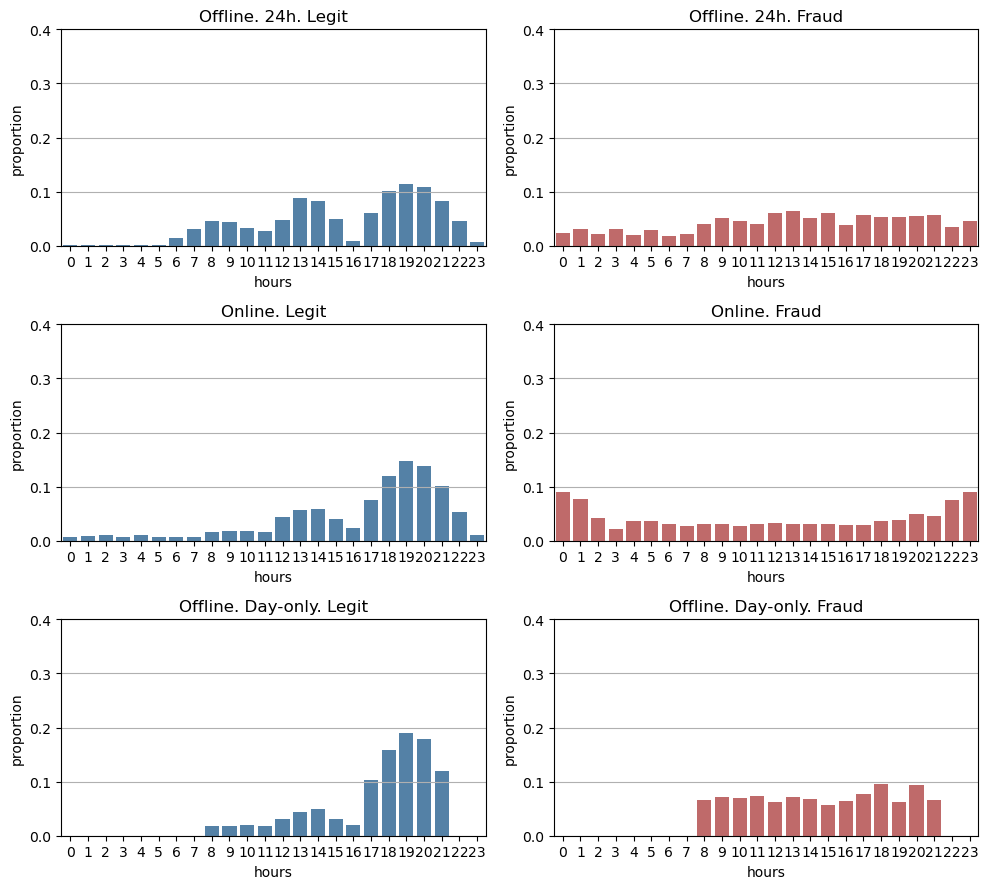

In [25]:
plot_all_patterns(time_weights_test)

In [26]:
# строим графики всех распределений

# fig, axes = plt.subplots(nrows=6, figsize=(7, 6*3))

# for ax, weight_args_key in zip(axes, time_weight_args.keys()):
#     weights, title, color = gen_weights_for_time(**time_weight_args[weight_args_key])
#     plot_time_weights(weights, title, color, ax)

# plt.tight_layout()
# plt.show()

## Проверка функции `gen_weights_for_time` на генерацию пустых значений
Запустим функцию 100 раз для каждого типа распределения и проверим были ли случаи когда для какого-то часа не создался вес.
Будет посчитано количество случаев когда создалось распределение с весами не для всех часов, которые указаны в периоде для распределения

In [27]:
# словарь для подсчета распределений в которых были пустые значения
empt = defaultdict(int)

# итерирование через варианты распределений
for preset in time_weight_args.keys():
    i = 0
    
    round_clock =  time_weight_args[preset]["round_clock"]

    # создать каждое распределение 100 раз
    while i < 100:
        weights, _, _ = gen_weights_for_time(**time_weight_args[preset])
        
        # если круглосуточное распределение и меньше 24 записей
        if round_clock and weights.shape[0] < 24:
            empt[preset] += 1
            
        # если чисто дневное распределение и меньше 14 записей (22 - 8)
        elif not round_clock and weights[weights.proportion != 0].shape[0] < (22 - 8):
            empt[preset] += 1
        

        # if round_clock:
        #     print(f"{preset} - {weights.shape[0]}")
        # elif not round_clock:
        #     print(f"{preset} - {weights[weights.proportion != 0].shape[0]}")

        i += 1

# если словарь не пуст, то ошибка
if empt:
    raise ValueError(f"Some time distributions may generate 0 values. {empt}")
else:
    print("No empty values generated in distributions")

No empty values generated in distributions


# Выбор случайного времени для транзакции
Оно будет основано на созданных ранее весах.
Но нам также понадобятся данные о категориях покупок, тоже нужны веса категорий и их информация: онлайн/оффлайн, круглосуточная/некруглосуточная, вероятность фрода. Далее мы создадим небольшой датафрейм с нужными данными для категории

## Создание признаков для категорий покупок

In [35]:
# category_stats загружен ранее из csv.
# добавим колонку онлайн или не онлайн категория со значениями True и False соответсвенно

category_stats.loc[category_stats.category.str.contains("net"), "online"] = True
category_stats.loc[~category_stats.category.str.contains("net"), "online"] = False
category_stats.head(6)

,category,avg_amt,amt_std,cat_count,online
0,gas_transport,63.577001,15.828399,56370,False
1,grocery_pos,115.885327,51.552330,52553,False
2,home,57.995413,48.085281,52345,False
3,shopping_pos,76.862457,232.484678,49791,False
4,kids_pets,57.506913,48.748482,48692,False
5,shopping_net,83.481653,237.219758,41779,True


In [36]:
# добавим долю категории, ее "вес" среди категорий - для определения распростаненности категории

category_stats["share"] = category_stats.cat_count.div(category_stats.cat_count.sum())
category_stats.head()

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,63.577001,15.828399,56370,False,0.101436
1,grocery_pos,115.885327,51.552330,52553,False,0.094568
2,home,57.995413,48.085281,52345,False,0.094193
3,shopping_pos,76.862457,232.484678,49791,False,0.089597
4,kids_pets,57.506913,48.748482,48692,False,0.087620


In [37]:
category_stats_final = category_stats.copy()

In [38]:
# умножим средние суммы транзакций по категориям и стандартное отклонение сумм на 10, для приближенности к ценам в рублях

category_stats_final[["avg_amt","amt_std"]] = category_stats_final[["avg_amt","amt_std"]] * 10
category_stats_final

,category,avg_amt,amt_std,cat_count,online,share
0,gas_transport,635.770012,158.283987,56370,False,0.101436
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568
2,home,579.954129,480.852810,52345,False,0.094193
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597
4,kids_pets,575.069126,487.484822,48692,False,0.087620
5,shopping_net,834.816532,2372.197581,41779,True,0.075180
6,entertainment,639.848399,642.299347,40104,False,0.072166
7,personal_care,482.330206,494.109413,39327,False,0.070768
8,food_dining,507.779383,484.490535,39268,False,0.070662
9,health_fitness,538.674317,479.652511,36674,False,0.065994


In [39]:
# Найдем количество фрода по категориям из датасета kaggle. Для определения вероятности фрода при генерации транзакций

fraud_trans_count_by_cat = fraud_kaggle.query("is_fraud == 1") \
                                        .groupby("category", as_index=False).agg({"trans_num":"count"}) \
                                        .rename(columns={"trans_num":"fraud_count"})
fraud_trans_count_by_cat.head()

,category,fraud_count
0,entertainment,59
1,food_dining,54
2,gas_transport,154
3,grocery_net,41
4,grocery_pos,485


In [40]:
cat_stats_full = category_stats_final.merge(fraud_trans_count_by_cat, on="category")
cat_stats_full.head(3)

,category,avg_amt,amt_std,cat_count,online,share,fraud_count
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485
2,home,579.954129,480.852810,52345,False,0.094193,67


In [41]:
# доля фрода в категории

cat_stats_full["fraud_share"] = cat_stats_full.fraud_count.div(cat_stats_full.cat_count)
cat_stats_full.head()

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335


In [47]:
# Добавим критерий возможности круглосуточной покупки в категории

cat_stats_full["round_clock"] = False

round_clock = ['gas_transport', 'grocery_pos','shopping_net', 'food_dining', 'misc_pos', 'misc_net', 'grocery_net']

for category in round_clock:
    cat_stats_full.loc[cat_stats_full.category == category, "round_clock"] = True
cat_stats_full

,category,avg_amt,amt_std,cat_count,online,share,fraud_count,fraud_share,round_clock
0,gas_transport,635.770012,158.283987,56370,False,0.101436,154,0.002732,True
1,grocery_pos,1158.853270,515.523301,52553,False,0.094568,485,0.009229,True
2,home,579.954129,480.852810,52345,False,0.094193,67,0.001280,False
3,shopping_pos,768.624573,2324.846777,49791,False,0.089597,213,0.004278,False
4,kids_pets,575.069126,487.484822,48692,False,0.087620,65,0.001335,False
5,shopping_net,834.816532,2372.197581,41779,True,0.075180,506,0.012111,True
6,entertainment,639.848399,642.299347,40104,False,0.072166,59,0.001471,False
7,personal_care,482.330206,494.109413,39327,False,0.070768,70,0.001780,False
8,food_dining,507.779383,484.490535,39268,False,0.070662,54,0.001375,True
9,health_fitness,538.674317,479.652511,36674,False,0.065994,52,0.001418,False


## Прототипирование выбора случайного времени

In [131]:
# создадим тестовый датафрейм транзакций для отладки функции генерации timestamp-а транзакции
# GeoDataFrame т.к. в данных будет география транзакции

trans_time_test = gpd.GeoDataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "time": pd.Series(dtype="datetime64[ns]"),
             "unix_time":pd.Series(dtype="int64"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="int64"),
            "merchant_id":pd.Series(dtype="int64"),
            "merchant_loc":pd.Series(dtype="geometry"),
            "client_ip":pd.Series(dtype="string"),
            "ip_location": pd.Series(dtype="string"),
             "account_to": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="int64")})
trans_time_test

,client_id,time,unix_time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud


In [29]:
timestamps = pd.DataFrame(pd.Series(pd.date_range(pd.to_datetime("2017-01-01", format="%Y-%m-%d"), \
                                                  pd.to_datetime("2022-12-31", format="%Y-%m-%d"), freq='min'), name="timestamp"))
timestamps["hour"] = timestamps.timestamp.dt.hour

In [128]:
timestamps["unix_time"] = (timestamps.timestamp - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

In [129]:
timestamps.shape

(3153601, 3)

In [130]:
timestamps.head()

,timestamp,hour,unix_time
0,2017-01-01 00:00:00,0,1483228800
1,2017-01-01 00:01:00,0,1483228860
2,2017-01-01 00:02:00,0,1483228920
3,2017-01-01 00:03:00,0,1483228980
4,2017-01-01 00:04:00,0,1483229040


In [52]:
time_weights = get_all_time_patterns(time_weight_args)

In [53]:
from functools import reduce

In [ ]:
# reduce + assign ? или reduce + rename скорее?

reduce(lambda left, right: left.merge(right, on="hour" 

In [57]:
timestamps.merge(time_weights["Offline_24h_Legit"]["weights"], left_on="hour", right_on="hours")

,timestamp,hour,hours,proportion
0,2017-01-01 00:00:00,0,0,0.001329
1,2017-01-01 00:01:00,0,0,0.001329
2,2017-01-01 00:02:00,0,0,0.001329
3,2017-01-01 00:03:00,0,0,0.001329
4,2017-01-01 00:04:00,0,0,0.001329
...,...,...,...,...
3153596,2022-12-30 23:56:00,23,23,0.008786
3153597,2022-12-30 23:57:00,23,23,0.008786
3153598,2022-12-30 23:58:00,23,23,0.008786
3153599,2022-12-30 23:59:00,23,23,0.008786


In [32]:
day_time = timestamps[(timestamps.hour >= 8) & (timestamps.hour < 22)].reset_index(drop=True)
day_time

,timestamp,hour
0,2017-01-01 08:00:00,8
1,2017-01-01 08:01:00,8
2,2017-01-01 08:02:00,8
3,2017-01-01 08:03:00,8
4,2017-01-01 08:04:00,8
...,...,...
1839595,2022-12-30 21:55:00,21
1839596,2022-12-30 21:56:00,21
1839597,2022-12-30 21:57:00,21
1839598,2022-12-30 21:58:00,21


# Функция `get_time_for_trans` - 03.06 см.ниже

In [106]:
timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]
weights = time_weights["Offline_Day_Fraud"]["weights"]
hours = weights.hours
txn_hour = weights.hours.sample(n=1, weights=weights.proportion, replace=True).iloc[0]
timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
txn_time

Timestamp('2017-01-02 16:57:00')

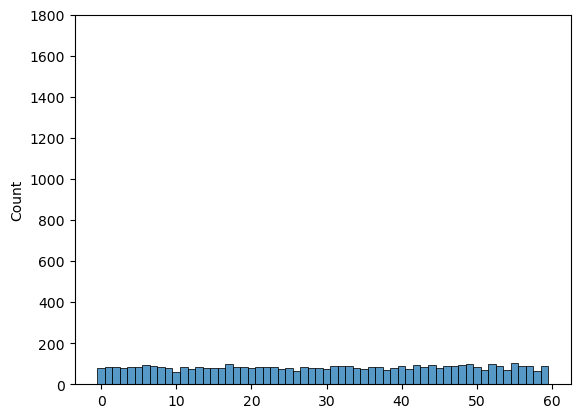

In [94]:
weights = time_weights["Offline_Day_Fraud"]["weights"]
hours = weights.hours
txn_hour = weights.hours.sample(n=1, weights=weights.proportion, replace=True).iloc[0]
timestamps_subset = timestamps.loc[timestamps.hour == txn_hour]
txn_time = timestamps_subset.timestamp.sample(n=5000, replace=True)
txn_minute = txn_time.dt.minute
fig, ax = plt.subplots()
sns.histplot(x=txn_minute.values, ax=ax, binwidth=1, discrete=True)
# ax.set_xlim(-0.5, 23.5)
ax.set_ylim(0,1800);

In [60]:


# if not is_fraud and round_clock and not online:
#     offline_24h_legit = time_weights["Offline_24h_Legit"]["weights"]
#     get_time_for_trans(trans_df, client_id, is_fraud, round_clock, online, offline_24h_legit, timestamps)

# elif is_fraud and round_clock and not online:
#     offline_24h_fraud = time_weights["Offline_24h_Fraud"]["weights"]
#     get_time_for_trans(trans_df, client_id, is_fraud, round_clock, online, offline_24h_fraud, timestamps)

In [137]:
(pd.Timestamp("1991-12-31") - pd.Timestamp("1970-01-01") )// pd.Timedelta('1s')

694137600

In [138]:
pd.to_datetime(694137600, unit="s")

Timestamp('1991-12-31 00:00:00')

# `get_time_for_trans` 03.06 - остановился на том, что написал генерацию времени для фрод транзакций с быстрой сменой гео
для другого фрода просто любое время наверное можно выбирать

In [ ]:
def get_time_for_trans(trans_df, client_id, is_fraud, round_clock, online, rule, geo_distance, time_weights, timestamps):
    """
    trans_df - датафрейм с транзакциями. Откуда брать информацию по предыдущим транзакциям
    client_id - id клиента, число, клиент чьи транзакции проверяются
    is_fraud - boolean. Фрод или не фрод
    round_clock - 
    online - boolean. Онлайн или оффлайн покупка. True or False
    rule - строка. Название антифрод правила
    geo_distance - число. Дистанция между локацией последней и текущей транзакции если фрод со сменой геолокации - в метрах
    time_weights - датафрейм с весами часов в периоде времени
    timestamps - датафрейм с timestamps
    """
    
    # timestamp последней транзакции клиента
    last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
    last_txn_unix = trans_df[trans_df.client_id == client_id].unix_time.max()
    
    # Если нет предыдущей транзакции т.е. нет последнего времени
    if not is_fraud and last_txn_time is pd.NaT:
        # берем первый год всего времененного периода т.к. это первая транзакция, пусть будет создана в первом году
        timestamps_1st_year = timestamps.loc[timestamps.timestamp.dt.year == timestamps.timestamp.dt.year.min()]
        
        hours = time_weights.hours
        txn_hour = time_weights.hours.sample(n=1, weights=time_weights.proportion, replace=True).iloc[0]
        timestamps_subset = timestamps_1st_year.loc[timestamps_1st_year.hour == txn_hour]
        txn_time = timestamps_subset.timestamp.sample(n=1, replace=True).iloc[0]
        txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

    # Если есть предыдущая транзакция

    # Не фрод
    elif not is_fraud:
        
        timestamp_sample = timestamps.sample(n=1, replace=True)
        trans_time_diff = timestamp_sample.unix_time - last_txn_unix
        pos_one_hour_diff = 3600
        neg_one_hour_diff = -3600
        
        # если время между текущей и последней транзакцией меньше часа в положительную сторону,
        # то увеличим время чтобы разница была минимум час 
        if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
            time_addition = pos_one_hour_diff - trans_time_diff
            txn_unix = txn_unix + time_addition
            txn_time = pd.to_datetime(txn_unix, unit="s")
        
        # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, 
        # то уменьшим время чтобы разница была минимум час
        elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
            time_subtraction = neg_one_hour_diff - trans_time_diff
            txn_unix = txn_unix + time_subtraction
            txn_time = pd.to_datetime(txn_unix, unit="s")

    # Фрод. Оффлайн. Правило: другая гео за короткое время
    elif is_fraud and not online and rule == "fast_geo_change":
        # Выставим порог скорости перемещения между точками транзакций - м/с
        # выше порога - детект как фрода. 
        # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
        # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
        speed_threshold = 800 / 3.6
        
        # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
        # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
        # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
        # но в зависимости от расстояния мы берем разные границы для распределений, чтобы не было перекоса в очень быстрое время. 
        # Также 20 минут я случайно взял как средний интервал для подобной фрод транзакции
        
        if geo_distance < 1000_000:
            fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
        elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
            fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
        elif geo_distance > 3000_000 and geo_distance <= 6000_000:
            fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
        else:
            fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6
        time_interval = geo_distance / fact_speed
        
        txn_unix = last_txn_unix + time_interval
        txn_time = pd.to_datetime(txn_unix, unit="s")

        
# время транзакции в виде timestamp и unix time
return txn_time, txn_unix
    

**Тест блока функции по генерации времени для быстрой смены гео**

In [313]:
# last_txn_time = pd.to_datetime("2025-06-07 15:01:00", format="%Y-%m-%d %H:%M:%S")
# last_txn_unix = (last_txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')
# distances = [500, 1500, 7500]

# dist_times = defaultdict(list)

# # geo_distance = 200_000
# for distance in distances:
#     geo_distance = distance * 1000
#     for _ in range(30):
        
#         # порог скорости перемещения между точками транзакций - м/с
#         # выше порога - детект как фрода. 
#         # Это нужно чтобы генерировать соответствующее время в зависимости от дистанции между точками транзакций
#         # пусть будет порог в 800 км/ч. Делим на 3.6 для перевода в м/с
#         speed_threshold = int(800 / 3.6)
                
#         # Случайно сгенерированная фактическая скорость превышающая легитимный порог. Допустим от 801 до 36000 км/ч
#         # до 36000 км/ч т.к. грубо говоря транзакция может быть совершена через 20 минут в 9000 км от предыдущей т.е. как-будто бы скорость 36000 км/ч
#         # 9000 км взяты как весьма примерное, самое длинное возможное расстояние между городами России при путешествии самолетом.
        
#         if geo_distance < 1000_000:
#             fact_speed = random.randint(speed_threshold + 1, 3000) / 3.6
#         elif geo_distance >= 1000_000 and geo_distance <= 3000_000:
#             fact_speed = random.randint(speed_threshold + 1, 9000) / 3.6
#         elif geo_distance > 3000_000 and geo_distance <= 6000_000:
#             fact_speed = random.randint(speed_threshold + 1, 18000) / 3.6
#         else:
#             fact_speed = random.randint(speed_threshold + 1, 36000) / 3.6
#         #
#         time_interval = geo_distance / fact_speed
        
#         txn_unix = last_txn_unix + time_interval
#         txn_time = pd.to_datetime(txn_unix, unit="s")
#         minutes = pd.Timedelta(time_interval, unit="s").components.minutes
#         # print(pd.Timedelta(time_interval, unit="s").components.minutes)
#         last_txn_time, txn_time
#         dist_times[distance].append(minutes)
#     dist_times[distance] = pd.Series(dist_times[distance]).mean()

In [314]:
dist_times

defaultdict(list,
            {500: np.float64(22.6),
             1500: np.float64(20.166666666666668),
             7500: np.float64(22.766666666666666)})

In [169]:
time_interval / 60

25.473532589124954

**тест блока функции по увеличению разрыва времени**

In [165]:
# last_txn_time = pd.to_datetime("2025-06-07 15:01:00", format="%Y-%m-%d %H:%M:%S")
# last_txn_unix = (last_txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# txn_time = pd.to_datetime("2025-06-07 15:39:00", format="%Y-%m-%d %H:%M:%S")
# txn_unix = (txn_time - pd.Timestamp("1970-01-01")) // pd.Timedelta('1s')

# trans_time_diff = txn_unix - last_txn_unix
# pos_one_hour_diff = 3600
# neg_one_hour_diff = -3600

# # если время между текущей и последней транзакцией меньше часа в положительную сторону, то увеличим время чтобы было час минимум
# if trans_time_diff < pos_one_hour_diff and trans_time_diff >= 0:
#     print("condition #1")
#     time_addition = pos_one_hour_diff - trans_time_diff
#     txn_unix_upd = txn_unix + time_addition
#     txn_time_upd = pd.to_datetime(txn_unix_upd, unit="s")

# # если время между текущей и последней транзакцией меньше часа в отрицательную сторону, то уменьшим время чтобы было час минимум
# elif trans_time_diff > neg_one_hour_diff and trans_time_diff < 0:
#     print("condition #2")
#     time_subtraction = neg_one_hour_diff - trans_time_diff
#     txn_unix_upd = txn_unix + time_subtraction
#     txn_time_upd = pd.to_datetime(txn_unix_upd, unit="s")

In [163]:
last_txn_time, txn_time_upd

(Timestamp('2025-06-07 15:01:00'), Timestamp('2025-06-07 16:01:00'))

In [164]:
last_txn_unix - txn_unix_upd

-3600

In [1110]:
def select_weights_for_time(is_fraud, round_clock, online):
    """
    генерация весов 
    round_clock - круглые сутки или нет. True или False соотвественно
    is_fraud - фрод или нет. True или False соотвественно
    """

    # Генерация


    
    if round_clock and not is_fraud:
        

_IncompleteInputError: incomplete input (1466952943.py, line 9)

# Основная функция генератор транзакций

In [1297]:
# Генерация POS транзакций
def generate_pos_transactions(client_info, start_date, end_date, categories, fraud_ips, trans_df, merchants_df \
                              ,online_merchant_ids, num=50, fraud_rate=0.05):
    """
    client_info  - датафрейм с данными клиента
    start_date - первая транзакция
    end_date - последняя транзакция
    num - количество транзакций на клиента
    fraud_rate - доля фрода во всех транзакциях
    categories - датафрейм с категориями и их характеристиками
    fraud_ips - датафрейм с фродовыми ip адресами
    trans_df - датафрейм с транзакциями.
               Куда их писать и куда обращаться за информацией по предыдущим транзакциям
    merchants_df - датафрейм с оффлайн мерачантами
    online_merchant_ids - id для онлайн мерчантов
    """
    timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    day_time = timestamps[(timestamps.dt.hour >= 6) & (timestamps.dt.hour < 22)].reset_index(drop=True)
    night_time = timestamps[((timestamps.dt.hour < 6) & (timestamps.dt.hour >= 0)) \
                | (timestamps.dt.hour >= 22) & (timestamps.dt.hour <= 23)] \
                .reset_index(drop=True)

    def get_time_for_trans(trans_df, client_id, round_clock_cat, is_fraud):
        # дата и время последней транзакции клиента
        last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
        
        # если нет предыдущей транзакции
        if last_txn_time is np.nan:
            if round_clock_cat == 1 and not is_fraud:
                txn_time = timestamps.sample(n=1, weights=, replace=True).iloc[0]

            else:
                txn_time = day_time.sample(n=1, replace=True).iloc[0]

        # если есть предыдущая транзакция
        else:
            txn_time = timestamps.sample(n=1, replace=True).iloc[0]
            trans_time_diff = txn_time - last_txn_time
            one_hour_delta = pd.Timedelta(3600, unit="s")

            # если время между текущей и последней транзакцией меньше часа, то добавим время чтобы было час минимум
            if trans_time_diff < one_hour_delta:
                time_addition = one_hour_delta - trans_time_diff
                txn_time = txn_time + time_addition
    
    for lab, row in client_info.iterrows():
        pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

        
        # данные клиента
        client_id = client_info.loc[lab, "client_id"]
        client_area = client_info.loc[lab, "area"]
        client_area_geometry = client_info.loc[lab, "geometry"]
        client_ip = client_info.loc[lab, "home_ip"]

        # цикл создания n транзакций для текущего клиента
        for _ in range(num):
            
                    
            # случайный выбор категории транзакции    
            category = categories.sample(1, replace=True, weights=categories.share)
            category_name = category["category"].iloc[0]
            round_clock = category["round_clock_cat"].iloc[0]
            # средняя сумма для этой категории
            amt_mean = category["avg_amt"].iloc[0]
            # стандартное отклонение сумм для этой категории
            amt_std = category["amt_std"].iloc[0]
            # случайно сгенерированная сумма не менее 1
            amount = max(1, np.random.normal(amt_mean, amt_std))

            # будет ли транзакция фродом или нет. 
            is_fraud = random.random() < fraud_rate

            # генерация данных для оффлайн покупок - не фрод
            if category["online"].iloc[0] == 0 and not is_fraud:
                merchant = merchants_df.loc[(merchants_df.area == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
                merchant_id = merchant["merchant_id"].iloc[0]
                merchant_loc = merchant["merchant_loc"].iloc[0]
                
                pos_txns.append({
                "client_id": client_id, "time": txn_time, "amount": round(amount, 2), "type": "purchase",
                "channel": "POS", "category": category_name, "online": category["online"].iloc[0],
                "merchant_id": merchant_id, "merchant_loc": merchant_loc, "is_fraud": is_fraud
            })

            trans_df_one_client = pd.DataFrame(pos_txns)
        trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

    return trans_df

SyntaxError: expected argument value expression (2438120794.py, line 31)

### Создадим пустой датафрейм для записи транзакций в него

In [ ]:
transactions = gpd.GeoDataFrame(
            {"client_id": pd.Series(dtype="int64"),
            "time": pd.Series(dtype="datetime64[ns]"),
            "amount": pd.Series(dtype="float64"),
            "type": pd.Series(dtype="string"),
            "channel": pd.Series(dtype="string"),
            "category": pd.Series(dtype="string"),
            "online":pd.Series(dtype="int64"),
            "merchant_id":pd.Series(dtype="int64"),
            "merchant_loc":pd.Series(dtype="geometry"),
            "client_ip":pd.Series(dtype="string"),
            "ip_location": pd.Series(dtype="string"),
             "account_to": pd.Series(dtype="int64"),
            "is_fraud": pd.Series(dtype="int64")})
transactions

In [ ]:
client_subset = clients_with_geo.query("client_id == 1")

In [ ]:
client_subset

In [ ]:
trans_for_test = transactions.copy()
trans_for_test

In [ ]:
trans_gen_test_01 = generate_pos_transactions(client_info=client_subset, start_date="2017-01-01", end_date="2022-12-31", num=5, fraud_rate=0.05, \
                              categories=cat_stats_full, fraud_ips=fraud_ips, trans_df=trans_for_test, \
                              merchants_df = selling_points_8_merchants, online_merchant_ids=online_merchant_ids)

In [ ]:
trans_gen_test_01.sort_values("time")

In [1038]:
legit_merge_hour_and_total = legit_by_cat_and_hour.merge(legit_kaggle_by_cat, on="category") \
                                                [["category", "trans_hour", "trans_count", "total_trans"]] \
                                                .sort_values(["category", "trans_hour"])
legit_merge_hour_and_total.shape

In [1039]:
# legit_merge_hour_and_total["hour_share"] = legit_merge_hour_and_total.trans_count.div(legit_merge_hour_and_total.total_trans)
# legit_merge_hour_and_total.head()

In [1037]:
# fig, axes = plt.subplots(nrows=cat_stats_full.shape[0], figsize=(10, 60))

# # df = legit_merge_hour_and_total.query("category == 'health_fitness'")
# for ax, category in zip(axes, cat_stats_full["category"]):
#     sns.lineplot(data=legit_merge_hour_and_total.query("category == @category"), x="trans_hour", y="hour_share", ax=ax)
#     ax.set_title(category)
#     ax.set_ylim(0)
# plt.tight_layout()    
# plt.show()

In [1026]:
# df = legit_merge_hour_and_total.query("category == 'grocery_pos'")

# p = sns.barplot(data=df, x="trans_hour", y="trans_count")
# p.set_ylim(0);

In [909]:
# Генерация POS транзакций
def generate_pos_transactions(client_info, start_date, end_date, categories, fraud_ips, trans_df, merchants_df \
                              ,online_merchant_ids, num=50, fraud_rate=0.05):
    """
    client_info  - датафрейм с данными клиента
    start_date - первая транзакция
    end_date - последняя транзакция
    num - количество транзакций на клиента
    fraud_rate - доля фрода во всех транзакциях
    categories - датафрейм с категориями и их характеристиками
    fraud_ips - датафрейм с фродовыми ip адресами
    trans_df - датафрейм с транзакциями.
               Куда их писать и куда обращаться за информацией по предыдущим транзакциям
    merchants_df - датафрейм с оффлайн мерачантами
    online_merchant_ids - id для онлайн мерчантов
    """
    timestamps = pd.Series(pd.date_range(pd.to_datetime(start_date), pd.to_datetime(end_date), freq='min'))
    
    day_time = timestamps[(timestamps.dt.hour >= 6) & (timestamps.dt.hour < 22)].reset_index(drop=True)
    night_time = timestamps[((timestamps.dt.hour < 6) & (timestamps.dt.hour >= 0)) \
                | (timestamps.dt.hour >= 22) & (timestamps.dt.hour <= 23)] \
                .reset_index(drop=True)

    def get_time_for_trans(trans_df, client_id, round_clock_cat, is_fraud):
        # дата и время последней транзакции клиента
        last_txn_time = trans_df[trans_df.client_id == client_id].time.max()
        
        # если нет предыдущей транзакции
        if last_txn_time is np.nan:
            if round_clock_cat == 1 and not is_fraud:
                txn_time = timestamps.sample(n=1, weights=, replace=True).iloc[0]

            else:
                txn_time = day_time.sample(n=1, replace=True).iloc[0]

        # если есть предыдущая транзакция
        else:
            txn_time = timestamps.sample(n=1, replace=True).iloc[0]
            trans_time_diff = txn_time - last_txn_time
            one_hour_delta = pd.Timedelta(3600, unit="s")

            # если время между текущей и последней транзакцией меньше часа, то добавим время чтобы было час минимум
            if trans_time_diff < one_hour_delta:
                time_addition = one_hour_delta - trans_time_diff
                txn_time = txn_time + time_addition
    
    for lab, row in client_info.iterrows():
        pos_txns = [] # сюда временно будут добавляться созданные транзакции для текущего клиента

        
        # данные клиента
        client_id = client_info.loc[lab, "client_id"]
        client_area = client_info.loc[lab, "area"]
        client_area_geometry = client_info.loc[lab, "geometry"]
        client_ip = client_info.loc[lab, "home_ip"]

        # цикл создания n транзакций для текущего клиента
        for _ in range(num):
            
                    
            # случайный выбор категории транзакции    
            category = categories.sample(1, replace=True, weights=categories.share)
            category_name = category["category"].iloc[0]
            round_clock = category["round_clock_cat"].iloc[0]
            # средняя сумма для этой категории
            amt_mean = category["avg_amt"].iloc[0]
            # стандартное отклонение сумм для этой категории
            amt_std = category["amt_std"].iloc[0]
            # случайно сгенерированная сумма не менее 1
            amount = max(1, np.random.normal(amt_mean, amt_std))

            # будет ли транзакция фродом или нет. 
            is_fraud = random.random() < fraud_rate

            # генерация данных для оффлайн покупок - не фрод
            if category["online"].iloc[0] == 0 and not is_fraud:
                merchant = merchants_df.loc[(merchants_df.area == client_area) & (merchants_df.category == category_name)].sample(1, replace=True)
                merchant_id = merchant["merchant_id"].iloc[0]
                merchant_loc = merchant["merchant_loc"].iloc[0]
                
                pos_txns.append({
                "client_id": client_id, "time": txn_time, "amount": round(amount, 2), "type": "purchase",
                "channel": "POS", "category": category_name, "online": category["online"].iloc[0],
                "merchant_id": merchant_id, "merchant_loc": merchant_loc, "is_fraud": is_fraud
            })

            trans_df_one_client = pd.DataFrame(pos_txns)
        trans_df = pd.concat([trans_df, trans_df_one_client], ignore_index=True)

    return trans_df

In [872]:
client_subset = clients_with_geo.query("client_id == 1")

In [907]:
client_subset

,client_id,district_id,birth_date,sex,district_code,region,area,timezone,lat,lon,population,clients,geometry,home_ip
0,1,18,1970-12-13,female,18,Рязанская,Рязань,UTC+3,54.625457,39.735999,525062,60,"POLYGON ((39.53667 54.6385, 39.53677 54.63889,...",2.60.0.1


In [910]:
trans_for_test = transactions.copy()
trans_for_test

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud


In [911]:
trans_gen_test_01 = generate_pos_transactions(client_info=client_subset, start_date="2017-01-01", end_date="2022-12-31", num=5, fraud_rate=0.05, \
                              categories=cat_stats_full, fraud_ips=fraud_ips, trans_df=trans_for_test, \
                              merchants_df = selling_points_8_merchants, online_merchant_ids=online_merchant_ids)

In [912]:
trans_gen_test_01.sort_values("time")

,client_id,time,amount,type,channel,category,online,merchant_id,merchant_loc,client_ip,ip_location,account_to,is_fraud
0,1,2020-06-17 15:32:00,388.33,purchase,POS,misc_pos,0.0,2876.0,POINT (39.58864244042683 54.64360405430491),<NA>,<NA>,NaN,0
1,1,2021-07-04 23:52:00,539.23,purchase,POS,personal_care,0.0,3729.0,POINT (39.74591808527166 54.637572015694126),<NA>,<NA>,NaN,0
2,1,2021-11-30 08:10:00,105.37,purchase,POS,kids_pets,0.0,6262.0,POINT (39.79949759003459 54.60411155098016),<NA>,<NA>,NaN,0


In [ ]:
# amounts = []
# category = cat_stats_full.sample(1, replace=True, weights=cat_stats_full.share)
# for _ in range(100):

    
#     amt_mean = category["avg_amt"].iloc[0]
#     amt_std = category["amt_std"].iloc[0]
#     amount = max(1, np.random.normal(amt_mean, amt_std))

#     amounts.append(amount)
#     # print(f"""
#     # Category: {category["category"]}
#     # Amount: {amount}
#     # """)

# print(f"""Category: {category["category"]}""")
# pd.Series(amounts).mean()

In [ ]:
# cat_stats_full.query("category == @category['category'].iloc[0]")

### Часть от оригинальной функции от GPT

In [908]:
                
            # генерация данных для онлайн покупок: ip
            # if category["online"] == 1:
                
            # Гео — нормальный город
            # city = random.choice(list(city_coords.keys()))
            # lat, lon = city_coords[city]
            # lat += np.random.normal(0, 0.01)
            # lon += np.random.normal(0, 0.01)
    
            
            # if is_fraud:
            #     # Фрод: другой город, высокая сумма, необычная категория
            #     category = "luxury"
            #     amount = np.random.uniform(20000, 150000)
            #     lat += np.random.normal(5, 2)  # далеко
            #     lon += np.random.normal(5, 2)
    
            # pos_txns.append({
            #     "client_id": client_id,
            #     "date": txn_date,
            #     "amount": round(amount, 2),
            #     "type": "purchase",
            #     "channel": "POS",
            #     "category": category,
            #     "latitude": lat,
            #     "longitude": lon,
            #     "is_fraud": is_fraud
            # })

    # return pd.DataFrame(pos_txns)

# Внизу образец генерации транзакций от GPT

In [ ]:
import random
from datetime import timedelta

# Категории и примерные средние суммы (можно расширить)
categories = {
    "grocery": (300, 100),
    "electronics": (10000, 5000),
    "transport": (150, 50),
    "restaurants": (800, 200),
    "clothing": (2000, 800)
}

# Список городов с координатами
city_coords = {
    "Москва": (55.75, 37.62),
    "Санкт-Петербург": (59.94, 30.31),
    "Казань": (55.79, 49.12),
    "Екатеринбург": (56.84, 60.61)
}

In [ ]:
# Генерация POS транзакций
def generate_pos_transactions(account_id, client_id, start_date, end_date, num=50, fraud_rate=0.05):
    dates = pd.date_range(start_date, end_date, freq='D').to_pydatetime().tolist()
    pos_txns = []

    for _ in range(num):
        txn_date = random.choice(dates)
        category = random.choice(list(categories.keys()))
        mean, std = categories[category]
        amount = max(1, np.random.normal(mean, std))

        # Гео — нормальный город
        city = random.choice(list(city_coords.keys()))
        lat, lon = city_coords[city]
        lat += np.random.normal(0, 0.01)
        lon += np.random.normal(0, 0.01)

        is_fraud = random.random() < fraud_rate
        if is_fraud:
            # Фрод: другой город, высокая сумма, необычная категория
            category = "luxury"
            amount = np.random.uniform(20000, 150000)
            lat += np.random.normal(5, 2)  # далеко
            lon += np.random.normal(5, 2)

        pos_txns.append({
            "account_id": account_id,
            "client_id": client_id,
            "date": txn_date,
            "amount": round(amount, 2),
            "type": "purchase",
            "channel": "POS",
            "category": category,
            "latitude": lat,
            "longitude": lon,
            "is_fraud": is_fraud
        })

    return pd.DataFrame(pos_txns)

## Нормальное распределение

In [707]:
# 56.310481, 43.989214

In [708]:
# 56.335365, 43.922722 # std


In [709]:
# 56.335365 - 56.304909

In [710]:
# 43.989214 - 43.922722

In [711]:
# from shapely.geometry import Point, Polygon

# def Random_Points_in_Bounds_Normal(polygon, number, mean_x, mean_y, std_x, std_y):   
    
#     x = np.random.normal(mean_x, std_x, number)
#     y = np.random.normal(mean_y, std_y, number)
#     return x, y

In [712]:
# nn_poly = district_ru_merge.query("area == 'Нижний Новгород'").iloc[0,-1]

In [713]:
# gdf_poly = gpd.GeoDataFrame(index=["myPoly"], geometry=[nn_poly])
# gdf_poly

In [714]:
# x,y = Random_Points_in_Bounds_Normal(nn_poly, 1000, mean_x=43.989214, mean_y= 56.310481, std_x=0.066491999, std_y=0.030456)
# df = pd.DataFrame()
# df['points'] = list(zip(x,y))
# df['points'] = df['points'].apply(Point)
# gdf_points = gpd.GeoDataFrame(df, geometry='points')

In [715]:
# Sjoin = gpd.tools.sjoin(gdf_points, gdf_poly, predicate="within", how='left')

# # Keep points in "myPoly"
# pnts_in_poly = gdf_points[Sjoin.index_right=='myPoly']

# # Plot result
# base = gdf_poly.boundary.plot(linewidth=1, edgecolor="black")
# gdf_points.plot(ax=base, linewidth=1, color="red", markersize=8)
# plt.show()

In [716]:
ru_cities_tent_subset.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [717]:
from shapely.ops import transform
from pyproj import Geod

# Две координаты: (долгота, широта)
coord1 = (37.6173, 55.7558)   # Москва
coord2 = (65.502079, 44.848393)   # Кызылорда 2300 km

# Геодезический расчёт по эллипсоиду WGS84
geod = Geod(ellps="WGS84")
distance_m = geod.inv(coord1[0], coord1[1], coord2[0], coord2[1])[-1]

print(f"Расстояние: {distance_m / 1000:.2f} км")

Расстояние: 2304.08 км


In [718]:
# files = os.listdir()
# files
# name_part = "10_kalin_ru"

# for file in files:
#     file_split =  file.split(".")
#     if file_split[0] == "gis_osm_places_a_free_1":
#         new_name = name_part + "." + file_split[-1]
#         print(new_name)
#         os.rename(file, new_name)
    # elif file_split[0] == "07_ural_ru":
    #     new_name = name_part + "." + file_split[-1]
    #     print(new_name)
    #     os.rename(file, new_name)
        
# os.rename("test.txt", "renamed")
# "asdasd.shp".split(".")[-1]

In [719]:
# os.chdir("./data/raw_data/geo/")

In [720]:
# gpd.read_file("data/raw_data/geo/01_central_ru.shp")

In [721]:
# # ru_city_shapes = 
# pd.concat([gpd.read_file(f"./data/raw_data/geo/{file}").query("fclass == 'city'") for file in geo_files])

In [722]:
# os.chdir("C:\\Users\\iaros\\My_documents\\Education\\projects\\fraud_detection_01\\")